In [1]:
# coding: utf-8

from pylab import *
import pandas as pd
import skimage
from skimage import io
from skimage import draw as dr
import os.path as osp
import os
import scipy.interpolate as sci
import sys
import pickle
# Enable inline plotting
%matplotlib inline
plt.style.use('ggplot') # Make the graphs a bit prettier
# figsize(15, 5)
pd.set_option("display.max_columns",60)
#pd.options.display.max_columns

color_list=[c['color'] for c in list(plt.rcParams['axes.prop_cycle'])]

In [201]:
def scale_dim(df,timescale,lengthscale):
    #time
    df['t']=df['frame']*timescale
    #length 
    for dim in ['x','y','z']:
        df[dim+'_scaled']=df[dim]/lengthscale
        
def compute_parameters(df):
    """This function computes different parameters: velocity, ... """
    r,c=df.shape
    
    #velocity components
    for dim in ['x','y','z']:
        a=np.empty(r)
        a[:]=np.nan
        df['v'+dim]=a
        groups=df.groupby(['traj'])
        for traj in df['traj'].unique():
            traj_group = groups.get_group(traj)
            components=(traj_group[dim+'_scaled'].shift(-1)-traj_group[dim+'_scaled'])/(traj_group['t'].shift(-1)-traj_group['t'])
            ind=traj_group.index.values
            df.loc[ind[1:],'v'+dim]=components[:-1].values
    #velocity modulus
    df['v']=sqrt(df['vx']**2+df['vy']**2+df['vz']**2)
    
def get_info(dirdata):
    filename=osp.join(dirdata,"info.txt")
    if osp.exists(filename):
        with open(filename) as f:
            info={'lengthscale':-1,'delta_t':-1,'columns':-1}
            for line in f:        
                if ('lengthscale' in line)==True:
                    if len(line.split())==3:
                        info['lengthscale']= float(line.split()[2])
                elif ('delta_t' in line)==True:
                    if len(line.split())==3:
                        info['delta_t'] = float(line.split()[2])
                elif ('columns' in line)==True:
                    if len(line.split())==3:
                        info['columns'] = line.split()[2].split(',')
    else: 
        print "ERROR: info.txt doesn't exist or is not at the right place"
    return info

def plot_frame_cells(df,groups,frame,data_dir,plot_traj=False,filtered_tracks=None,hide_labels=False):
    """ Print the tracked pictures with updated (=relinked) tracks"""
    print '\rplotting frame '+str(frame),
    sys.stdout.flush()
    if filtered_tracks is None:
        track_dir=osp.join(data_dir,'traj')
    else:
        track_dir=osp.join(data_dir,'traj_subset')
    if osp.isdir(track_dir)==False:
        os.mkdir(track_dir)
    group=groups.get_group(frame).reset_index(drop=True)
    r,c=group.shape
    if plot_traj:
        track_groups=df.groupby(['traj'])
    #import image
    filename=osp.join(data_dir,'raw/max_intensity_%04d.png'%int(frame))
    im = io.imread(filename)
    n,m,d = im.shape
    fig=figure(frameon=False)
    fig.set_size_inches(m/300,n/300)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(im,aspect='auto',origin='lower')
    xmin, ymin, xmax, ymax=ax.axis('off')
    if filtered_tracks is None:
        for i in range(0,r):
            #write label
            x=group.loc[i,'x']
            y=group.loc[i,'y']
            track=int(group.loc[i,'traj'])
            s='%d'%(track)
            if hide_labels is False:
                ax.text(x,y,s,fontsize=5,color='w')
            if plot_traj:
                #plot trajectory
                traj=get_obj_traj(track_groups,track,max_frame=frame)
                traj_length,c=traj.shape
                if traj_length>1:
                    ax.plot(traj['x'],traj['y'],ls='-',color=color_list[track%7])
                    ax.axis([xmin, ymin, xmax, ymax])

    else:
        for i,track in enumerate(filtered_tracks):
            if (group['traj']==track).any():
                #write label
                x=group[group['traj']==track]['x'].values[0]
                y=group[group['traj']==track]['y'].values[0]
                s='%d'%track
                if hide_labels is False:
                    ax.text(x,y,s,fontsize=5,color='w')
                if plot_traj:
                    #plot trajectory
                    traj=get_obj_traj(track_groups,track,max_frame=frame)
                    traj_length,c=traj.shape
                    if traj_length>1:
                        ax.plot(traj['x'],traj['y'],ls='-',color=color_list[i%7])
                        ax.axis([xmin, ymin, xmax, ymax])
    filename=osp.join(track_dir,'traj_%04d.png'%int(frame))
    fig.savefig(filename, dpi=300)
    close('all')
                      
def get_obj_traj(track_groups,track,max_frame=None):
    '''gets the trajectory of an object. track_groups is the output of a groupby(['relabel'])'''
    group=track_groups.get_group(track)
    trajectory=group[['frame','t','x','y','v']].copy()
    if max_frame is not None:
        trajectory=trajectory[trajectory['frame']<=max_frame]
    return trajectory.reset_index(drop=True)

def plot_frame_vfield(df,groups,frame,data_dir,interpolate=False,filtered_tracks=False,grid_step=10):
    """ Print the tracked pictures with updated (=relinked) tracks"""
    print '\rplotting frame '+str(frame),
    sys.stdout.flush()
    if filtered_tracks:
        track_dir=osp.join(data_dir,'vfield_subset')
    else:
        track_dir=osp.join(data_dir,'vfield')
        
    if osp.isdir(track_dir)==False:
        os.mkdir(track_dir)
    group=groups.get_group(frame).reset_index(drop=True)
    r,c=group.shape
    #import image
    filename=osp.join(data_dir,'raw/max_intensity_%04d.png'%int(frame))
    im = io.imread(filename)
    n,m,d = im.shape
    fig=figure(frameon=False)
    fig.set_size_inches(m/300,n/300)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(im,aspect='auto',origin='lower')
    xmin, ymin, xmax, ymax=ax.axis('off')
    if interpolate:
        grid_x, grid_y = np.mgrid[0:m:m/grid_step, 0:n:n/grid_step]
        grid=[]
        for p in ['vx','vy','vz']:
            points=df[['x','y']].values
            values=df[p].values
            grid.append(sci.griddata(points, values, (grid_x, grid_y), method='linear'))
        quiver(grid_x,grid_y,grid[0],grid[1],grid[2])
        ax.axis([xmin, ymin, xmax, ymax])
    else:
        Q=quiver(group['x'],group['y'],group['vx'],group['vy'],group['vz'],units='x',cmap='plasma')
        cbaxes = fig.add_axes([0.4, 0.935, 0.025, 0.05])
        cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
        cbaxes.tick_params(labelsize=5,color='w')
        cbaxes.yaxis.label.set_color('white')
        ax.axis([xmin, ymin, xmax, ymax])
    filename=osp.join(track_dir,'vfield_%04d.png'%int(frame))
    fig.savefig(filename, dpi=600)
    close('all')


In [121]:
def run(data_dir,refresh=False,plot_frame=True,plot_data=True,plot_modified_tracks=False,plot_all_traj=False):
    #import
    pickle_fn=osp.join(data_dir,"data_base.p")
    if osp.exists(pickle_fn)==False or refresh:
#         data=loadtxt(osp.join(data_dir,'test_data.txt'))
        data=loadtxt(osp.join(data_dir,'table.txt'))
        info=get_info(data_dir)
        for inf in ['lengthscale','delta_t','columns']:
            if info[inf]==-1:
                print "WARNING: "+inf+" not provided in info.txt"
        lengthscale=info["lengthscale"];timescale=info["delta_t"];columns=info["columns"]
        df=pd.DataFrame(data[:,1:],columns=columns) 
        #scale data
        scale_dim(df,timescale,lengthscale)
        compute_parameters(df)
        #update pickle
        pickle.dump(df, open( osp.join(data_dir,"data_base.p"), "wb" ) )
    else:
        df=pickle.load( open( pickle_fn, "rb" ))
    
    return df

#     #####################################
#     ######  Plotting starts here  #######
#     #####################################

#     if plot_frame:
#         groups = df.groupby(["ImageNumber"])
#         if plot_all_traj:
#             for frame in range(framemin,framemax+1):
#                 plot_frame_obj(df,groups,frame,data_dir,filtered_tracks=df['relabel'].values.tolist(),plot_traj=True)
#         else:
#             for frame in range(framemin,framemax+1):
#                 plot_frame_obj(df,groups,frame,data_dir)

#     #plot measurements
#     if plot_data:
#         print 'plotting data...'
#         tracks_to_plot=select_tracks(df,'long_track',min_track_length,timescale)
#         for param_y in param_y_list:
#             plot_params(df,tracks_to_plot,param_y,data_dir,param_x='Metadata_frame')
#         plot_hist_avg(df,tracks_to_plot,param_y_list,data_dir)

In [122]:
data_dir='/home/amichaut/Desktop/charlene'
df=run(data_dir,refresh=False)
df2=filter_by_traj_len(df,min_traj_len=25)

In [202]:
groups=df2.groupby('frame')
for frame in df['frame'].unique():
    plot_frame_vfield(df,groups,frame,data_dir,interpolate=False)
# plot_frame_vfield(df,groups,2,data_dir,interpolate=False)

plotting frame 24.0


In [197]:
# tracks=df.groupby('traj')
# long_tracks=[]
# for t in df['traj'].unique():
#     track=tracks.get_group(t)
#     if track.shape[0]==25:
#         long_tracks.append(t)
# print len(long_tracks)
groups=df2.groupby('frame')
for frame in df['frame'].unique():
    plot_frame_cells(df2,groups,frame,data_dir,plot_traj=True,hide_labels=True)


plotting frame 24.0


In [181]:
def filter_by_traj_len(df,min_traj_len=1,max_traj_len=None):
    df2=pd.DataFrame()
    if max_traj_len is None: #assign the longest possible track
        max_traj_len=df['frame'].max()-df['frame'].min()+1
    tracks=df.groupby('traj')
    for t in df['traj'].unique():
        track=tracks.get_group(t)
        if track.shape[0]>=min_traj_len and track.shape[0]<=max_traj_len:
            df2=pd.concat([df2,track])
    return df2


In [60]:
part_num=10
frame_num=25
x0=10;y0=10;z0=10
xmax=100;ymax=100;zmax=100;
shift=50
traj=array([]);frame=array([]);x=array([]);y=array([]);z=array([])
for i in range(part_num):
    traj=np.concatenate((traj,ones(frame_num)*i))
    frame=np.concatenate((frame,arange(frame_num)))
    x=np.concatenate((x,linspace(x0,xmax,frame_num)))
    y=np.concatenate((y,linspace(y0+i*shift,ymax+i*shift,frame_num)))
    z=np.concatenate((z,linspace(z0,zmax,frame_num)))

a=np.vstack([arange(frame_num*part_num),traj,frame,x,y,z,zeros((6,frame_num*part_num))]).T
    
df=pd.DataFrame(a,columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
savetxt('test_data.txt',a,delimiter='\t')

(0.0, 1.0, 0.0, 1.0)


[-1, 7, -1, 7]

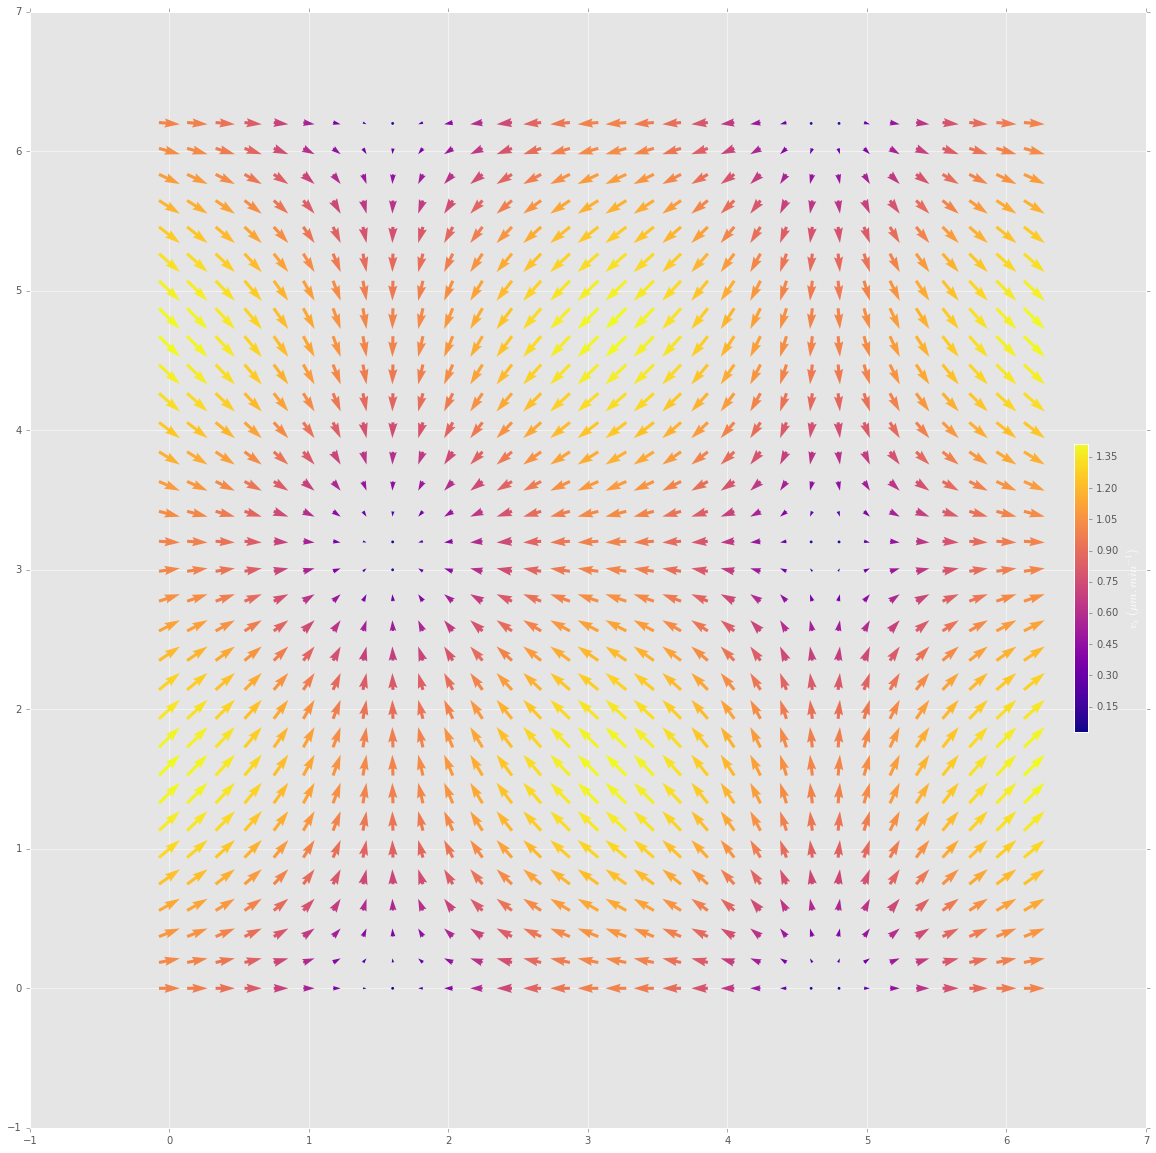

In [200]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig=plt.figure(figsize=(20,20))
ax=gca()
print ax.axis()
M = np.hypot(U, V)
Q = plt.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

xmin, ymin, xmax, ymax=ax.axis()

cbaxes = fig.add_axes([0.85, 0.4, 0.01, 0.2]) 
cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
cbaxes.yaxis.label.set_color('white')

# plt.plot(X, Y, 'k.')
ax.axis([-1, 7, -1, 7])
# plt.title("scales with x view; pivot='tip'")

In [210]:
%run analyze_traj.py
track_groups=df.groupby(['traj'])
traj=get_obj_traj(track_groups,3,max_frame=10)
traj

,frame,t,x,y,z,v
0,0.0,0.0,614.611,862.662,0.929,NaN
1,1.0,8.0,614.655,862.625,0.937,0.004536
2,2.0,16.0,614.841,863.531,0.897,0.072343
3,3.0,24.0,615.149,862.655,1.016,0.073156
4,4.0,32.0,615.255,863.884,0.963,0.096485
5,5.0,40.0,614.959,863.864,0.954,0.023194
6,6.0,48.0,614.518,863.555,0.990,0.042173
7,7.0,56.0,614.944,863.770,0.935,0.037536
8,8.0,64.0,614.723,863.654,0.843,0.020787
9,9.0,72.0,614.748,862.860,0.949,0.062628


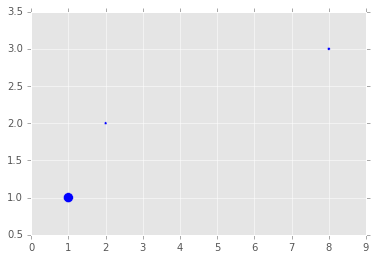

In [215]:
plt.scatter([1,2,8],[1,2,3],[100,8,9],cmap=cm.jet)

In [216]:
a=cm.jet(10,100)

In [218]:
a=get_cmap('plasma')

In [220]:
a.set_clim(10,15)

AttributeError: 'ListedColormap' object has no attribute 'set_clim'